In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab10.ipynb")

# Lab 10: SQL

In this lab, we are going to practice viewing, sorting, grouping, and merging tables with SQL. We will explore two datasets:
1. A "minified" version of the [Internet Movie Database](https://www.imdb.com/interfaces/) (IMDb). This SQLite database (~10MB) is a tiny sample of the much larger database (more than a few GBs). As a result, disclaimer that we may get wildly different results than if we use the whole database!

1. The money donated during the 2016 election using the [Federal Election Commission (FEC)'s public records](https://www.fec.gov/data/). You will be connecting to a SQLite database containing the data. The data we will be working with in this lab is relatively small (~106MB); however, it is a sample taken from a much larger database (more than a few GBs).


To receive credit for a lab, answer all questions correctly and submit before the deadline.

**The on-time deadline is Tuesday, November 12, 11:59 PM**. As a reminder, the slip-day policy does not apply to labs. We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline. This way, you will have ample time to contact staff for submission support.

### Important Note!

**Please only have ONE active SQL database running at once on DataHub, meaning do not have multiple homework/lab/lecture notebooks running at the same time**

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** the walkthrough video is from Spring 2022, where the format of answers was different than it is this semester.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("uQ3E4pejmD8", list = 'PLQCcNQgUcDfpdBnhS-lPq8LPas48tkMgp', listType = 'playlist')

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, common SQL errors, and more.

In [3]:
# Run this cell to set up your notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from pathlib import Path
from zipfile import ZipFile

if Path('../../../../../../../gradescope').is_dir():
    path = Path('.') 
else:
    path = Path('../../../../../../../tmp') 

with ZipFile('data.zip', 'r') as zipObj:
    # Extract all the contents of zip file to the tmp directory
    zipObj.extractall(path = path)
print(path)
imdb_sqlite_conn = 'duckdb:///' + str(path / 'imdbmini.db')
fec_nyc_sqlite_conn = 'duckdb:///' + str(path / 'fec_nyc.db')

..\..\..\..\..\..\..\tmp


## SQL Query Syntax

Throughout this lab, you will become familiar with the following syntax for the `SELECT` query:

```
SELECT <column list>
FROM <table>
[WHERE <predicate>]
[GROUP BY <column list>]
[HAVING <predicate>]
[ORDER BY <column list>]
[LIMIT <number of rows>]
[OFFSET <number of rows>]
```

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 0 [Tutorial]: Writing SQL in Jupyter Notebooks

**Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. To avoid printing out 100k-sized tables, we've adjusted the display limit to ensure that the tables displayed are truncated to 20 rows (though they may contain more rows in reality).


In [16]:
%config SqlMagic.displaylimit = 20
%config SqlMagic.style = 'DEFAULT'

In [17]:
# Run this cell to set up SQL. 
import duckdb
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### 1. `%%sql` cell magic

In lecture, we used the `sqlalchemy` extension to use **`%%sql` cell magic**, which enables us to connect to SQL databases and issue SQL commands within Jupyter Notebooks.

Run the below cells to connect to a mini IMDb database using `duckdb` as the backend.

In [18]:
# Run this cell to connect to duckdb
conn = duckdb.connect()
conn.query("INSTALL sqlite")

In [19]:
# Run this cell to connect to the imdbmini database
imdb_mini_db = 'duckdb:///' + str(path / 'imdbmini.db')
%sql duckdb:///../../../../../../../tmp/imdbmini.db --alias imdb_engine

Connecting to 'imdb_engine'

The above cell connects to the same database using the SQLAlchemy Python library, which can connect to several different database management systems, including sqlite3, MySQL, PostgreSQL, and Oracle; we use `duckdb`. The library also supports an advanced feature for generating queries called an [object relational mapper](https://docs.sqlalchemy.org/en/20/tutorial/index.html#unified-tutorial) or ORM, which we won't discuss in this course but is quite useful for application development.

Above, prefixing our single-line command with `%sql` means that the entire line will be treated as a SQL command (this is called "line magic"). In this class we will most often write multi-line SQL, meaning we need "cell magic", where the first line has `%%sql` (note the double `%` operator).

The database `imdbmini.db` includes several tables, one of which is `Name`. Running the below cell will return first 5 lines of that table. Note that `%%sql` is on its own line.

We've also included syntax for single-line comments, which are surrounded by `--`, and multi-line comments, which are surrounded by `/*` and `*/`.

In [21]:
%%sql
/*
 * This is a
 * multi-line comment.
 */
-- This is a single-line/inline comment. --
SELECT *
FROM Name
LIMIT 5;

Running query in 'imdb_engine'

nconst,primaryName,birthYear,deathYear,primaryProfession
1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
2,Lauren Bacall,1924,2014,"actress,soundtrack"
3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
4,John Belushi,1949,1982,"actor,soundtrack,writer"
5,Ingmar Bergman,1918,2007,"writer,director,actor"


<br/>

### 2. The `pandas` command `pd.read_sql`

This section describes how data scientists use SQL and `python` in practice, using the `pandas` command `pd.read_sql` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html)). **You will see both `%sql` magic and `pd.read_sql` in this course**.

With the SQLAlchemy object `engine`, we can call `pd.read_sql` which takes in a `query` **string**. Note the `"""` to define our multi-line string, which allows us to have a query span multiple lines. The resulting `DataFrame` `df` stores the results of the same SQL query from the previous section.

In [23]:
# Run this cell to see the demo.
query = """
SELECT *
FROM name
LIMIT 5;
"""

df = pd.read_sql(query, imdb_mini_db)
df

,nconst,primaryName,birthYear,deathYear,primaryProfession
0,1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,2,Lauren Bacall,1924,2014,"actress,soundtrack"
2,3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
3,4,John Belushi,1949,1982,"actor,soundtrack,writer"
4,5,Ingmar Bergman,1918,2007,"writer,director,actor"


#### `pd.read_sql` vs. `%sql` magic error messages

`pd.read_sql` has **long error messages**: Given that the SQL query is now in the string, the errors become more unintelligible. Consider the below (incorrect) query.

**Note**: Uncomment the below code and check out the error. You can uncomment/comment out multiple cells at the same time by selecting the lines and press ctrl+/ or command+/ 

In [24]:
# Uncomment the below code and check out the error.
query = """
SELECT *
FROM Title;
LIMIT 5
"""
pd.read_sql(query, imdb_mini_db)

ProgrammingError: (duckdb.duckdb.ParserException) Parser Error: syntax error at or near "LIMIT"
[SQL: 
SELECT *
FROM Title;
LIMIT 5
]
(Background on this error at: https://sqlalche.me/e/20/f405)

<br/>
<details>
<summary>Now that's an unruly error message! Can you see what's wrong in the cell above and correct the query? Toggle this cell to check your answer!</summary>
It has a semicolon in the wrong place!
</details>

<br/>

On the other hand, `%sql` magic gives more intelligible error messages, so we will use this format more often.

In [25]:
%%sql
-- Uncomment all this block and check out the error. --
SELECT *
FROM Title;
LIMIT 5

Running query in 'imdb_engine'

RuntimeError: If using snippets, you may pass the --with argument explicitly.
For more details please refer: https://jupysql.ploomber.io/en/latest/compose.html#with-argument


Original error message from DB driver:
(duckdb.duckdb.ParserException) Parser Error: syntax error at or near "LIMIT"
[SQL: LIMIT 5]
(Background on this error at: https://sqlalche.me/e/20/f405)

If you need help solving this issue, send us a message: https://ploomber.io/community


<br/>
<!-- 
TODO

### 3. A suggested workflow for writing SQL in Jupyter Notebooks

Which approach is better, `%sql` magic or `pd.read_sql`?

The SQL database generally contains much more data than what you would analyze in detail. As a `python`-fluent data scientist, you will often query SQL databases to perform initial exploratory data analysis, a subset of which you load into `python` for further processing.

In practice, you would likely use a combination of the two approaches. First, you'd try out some SQL queries with `%sql` magic to get an interesting subset of data. Then, you'd copy over the query into a `pd.read_sql` command for visualization, modeling, and export with `pandas`, sklearn, and other `python` libraries.

For SQL assignments in this course, to minimize unruly error messages while maximizing `python` compatibility, we suggest the following "sandboxed" workflow:
1. Create a `%%sql` magic cell using the code below. 

    ```
    %% sql
    -- This is a comment. Put your code here... --
    ```
    
<br/>

2. Work on the SQL query in the `%%sql` cell; e.g., `SELECT ... ;`
3. Then, once you're satisfied with your SQL query, copy it into the multi-string query in the answer cell (the one that contains the `pd.read_sql` call).

You don't have to follow the above workflow to get full credit on assignments, but we suggest it to reduce debugging headaches. We've created the scratchwork `%%sql` cells for you in this assignment—but **if you add any cells, please delete them before submitting**. Newly added cells will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file. -->


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: The IMDb (mini) Dataset

Let's explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we will use for the upcoming homework. We'll load it in using cell magic.

In [26]:
%%sql imdb_engine
SELECT * FROM sqlite_master WHERE type='table';

type,name,tbl_name,rootpage,sql
table,Title,Title,0,"CREATE TABLE Title(tconst BIGINT, titleType VARCHAR, primaryTitle VARCHAR, originalTitle VARCHAR, isAdult VARCHAR, startYear VARCHAR, endYear VARCHAR, runtimeMinutes VARCHAR, genres VARCHAR);"
table,Name,Name,0,"CREATE TABLE ""Name""(nconst BIGINT, primaryName VARCHAR, birthYear VARCHAR, deathYear VARCHAR, primaryProfession VARCHAR);"
table,Role,Role,0,"CREATE TABLE ""Role""(tconst BIGINT, ordering VARCHAR, nconst BIGINT, category VARCHAR, job VARCHAR, characters VARCHAR);"
table,Rating,Rating,0,"CREATE TABLE Rating(tconst BIGINT, averageRating VARCHAR, numVotes VARCHAR);"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details open>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (integer) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (text) – in YYYY format
- deathYear (text) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- ordering (text) – a number to uniquely identify rows for a given tconst
- nconst (integer) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- Year (text) – represents the release year of a title.
- runtimeMinutes (text)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>

From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* that `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

---

## Question 1

What are the different kinds of `titleType`s included in the `Title` table? Write a query to find out all the unique `titleType`s of films using the `DISTINCT` keyword.  (**You may not use `GROUP BY`.**)

In [35]:
%%sql imdb_engine --save query_q1
select distinct
titleType
from Title;

titleType
tvSeries
short
tvMovie
videoGame
tvSpecial
tvEpisode
video
tvMiniSeries
movie


In [36]:
# Run this cell for grading purposes. 
# No further action is required. 
sql_q1 = %sqlcmd snippets query_q1
res_q1 = pd.read_sql(sql_q1, imdb_mini_db)

In [37]:
grader.check("q1")

q1 results: All test cases passed!

<br><br>

---

## Question 2

Before we proceed we want to get a better picture of the kinds of jobs that exist.  To do this examine the `Role` table by computing the number of records with each job `category`.  Present the results in descending order by the total counts.

The top of your table should look like this (however, you should have more rows):

| |category|total|
|-----|-----|-----|
|**0**|actor|21665|
|**1**|writer|13830|
|**2**|...|...|

In [42]:
%%sql imdb_engine --save query_q2
select category,count(*) As total
from Role
group by category 
order by total Desc;

category,total
actor,21665
writer,13830
actress,12175
producer,11028
director,6995
composer,4123
cinematographer,2747
editor,1558
self,623
production_designer,410


In [43]:
# Run this cell for grading purposes. 
# No further action is required. 
sql_q2 = %sqlcmd snippets query_q2
res_q2 = pd.read_sql(sql_q2, imdb_mini_db)

In [44]:
grader.check("q2")

q2 results: All test cases passed!

<br/>
If we computed the results correctly we should see a nice horizontal bar chart of the counts per category below:

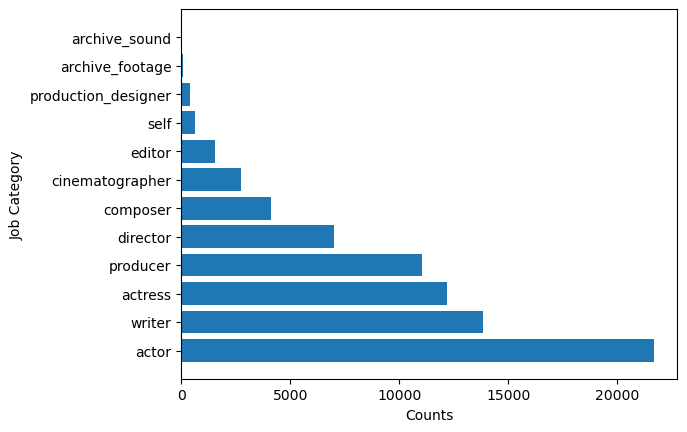

In [45]:
# Run this cell to make a bar plot.
plt.barh(res_q2["category"], res_q2["total"])
plt.xlabel("Counts")
plt.ylabel("Job Category");

<br/><br/>

---

## Question 3

Now that we have a better sense of the basics of our data, we can ask some more interesting questions.

The `Rating` table has the `numVotes` and the `averageRating` for each title. Which 10 films have the most ratings?

Write a SQL query that outputs three fields: the `title`, `numVotes`, and `averageRating` for the 10 films that have the highest number of ratings.  Sort the result in descending order by the number of votes.

**Hint**: The `numVotes` in the `Rating` table is not an integer! Use `CAST(Rating.numVotes AS int) AS numVotes` to convert the attribute to an integer. 

In [58]:
%%sql imdb_engine --save query_q3
select primaryTitle,CAST(R.numVotes AS int) AS numVotes, averageRating
FROM Title AS T INNER JOIN Rating AS R
ON T.tconst = R.tconst 
order by numVotes desc
limit 10;

primaryTitle,numVotes,averageRating
The Shawshank Redemption,2462686,9.3
The Dark Knight,2417875,9.0
Inception,2169255,8.8
Fight Club,1939312,8.8
Pulp Fiction,1907561,8.9
Forrest Gump,1903969,8.8
Game of Thrones,1874040,9.2
The Matrix,1756469,8.7
The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
The Lord of the Rings: The Return of the King,1709023,8.9


In [59]:
# No further action is required. 
sql_q3 = %sqlcmd snippets query_q3
res_q3 = pd.read_sql(sql_q3, imdb_mini_db)

In [60]:
grader.check("q3")

q3 results:
    q3 - 1 result:
        ✅ Test case passed

    q3 - 2 result:
        ❌ Test case failed
        Trying:
            set(res_q3.columns) == set(['title', 'numVotes', 'averageRating'])
        Expecting:
            True
        **********************************************************************
        Line 1, in q3 1
        Failed example:
            set(res_q3.columns) == set(['title', 'numVotes', 'averageRating'])
        Expected:
            True
        Got:
            False

    q3 - 3 result:
        ✅ Test case passed

    q3 - 4 result:
        ❌ Test case failed
        Trying:
            list(res_q3['title']) == ['The Shawshank Redemption', 'The Dark Knight', 'Inception', 'Fight Club', 'Pulp Fiction', 'Forrest Gump', 'Game of Thrones', 'The Matrix', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Return of the King']
        Expecting:
            True
        **********************************************************************
        Line 1, in q3 3
        Failed example:
            list(res_q3['title']) == ['The Shawshank Redemption', 'The Dark Knight', 'Inception', 'Fight Club', 'Pulp Fiction', 'Forrest Gump', 'Game of Thrones', 'The Matrix', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Return of the King']
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
                return self._engine.get_loc(casted_key)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
              File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
              File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
              File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
            KeyError: 'title'

            The above exception was the direct cause of the following exception:

            Traceback (most recent call last):
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q3 3[0]>", line 1, in <module>
                list(res_q3['title']) == ['The Shawshank Redemption', 'The Dark Knight', 'Inception', 'Fight Club', 'Pulp Fiction', 'Forrest Gump', 'Game of Thrones', 'The Matrix', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Return of the King']
                     ~~~~~~^^^^^^^^^
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\frame.py", line 4102, in __getitem__
                indexer = self.columns.get_loc(key)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
                raise KeyError(key) from err
            KeyError: 'title'

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Election Donations in New York City

Finally, let's analyze the Federal Election Commission (FEC)'s public records. We connect to the database using cell magic so that we can flexibly explore the database.

In [61]:
# Run this cell to connect to the fec_nyc database
fec_nyc_db = 'duckdb:///' + str(path / 'fec_nyc.db')
%sql duckdb:///../../../../../../../tmp/fec_nyc.db --alias fec_engine

Connecting and switching to connection 'fec_engine'

### Table Descriptions

Run the below cell to explore the **schemas** of all tables saved in the database.

If you'd like, you can consult the below linked FEC pages for the descriptions of the tables themselves.

* `cand` ([link](https://www.fec.gov/campaign-finance-data/candidate-summary-file-description/)): Candidates table. Contains names and party affiliation.
* `comm` ([link](https://www.fec.gov/campaign-finance-data/committee-summary-file-description/)): Committees table. Contains committee names and types.
* `indiv_sample_nyc` ([link](https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description)): All individual contributions from New York City .

In [62]:
%%sql 
/* just run this cell */
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'fec_engine'

type,name,tbl_name,rootpage,sql
table,comm,comm,0,"CREATE TABLE comm(cmte_id VARCHAR, cmte_nm VARCHAR, tres_nm VARCHAR, cmte_st1 VARCHAR, cmte_st2 VARCHAR, cmte_city VARCHAR, cmte_st VARCHAR, cmte_zip VARCHAR, cmte_dsgn VARCHAR, cmte_tp VARCHAR, cmte_pty_affiliation VARCHAR, cmte_filing_freq VARCHAR, org_tp VARCHAR, connected_org_nm VARCHAR, cand_id VARCHAR);"
table,indiv_sample_nyc,indiv_sample_nyc,0,"CREATE TABLE indiv_sample_nyc(cmte_id VARCHAR, amndt_ind VARCHAR, rpt_tp VARCHAR, transaction_pgi VARCHAR, image_num BIGINT, transaction_tp VARCHAR, entity_tp VARCHAR, ""name"" VARCHAR, city VARCHAR, state VARCHAR, zip_code VARCHAR, employer VARCHAR, occupation VARCHAR, transaction_dt VARCHAR, transaction_amt BIGINT, other_id VARCHAR, tran_id VARCHAR, file_num BIGINT, memo_cd VARCHAR, memo_text VARCHAR, sub_id BIGINT);"
table,cand,cand,0,"CREATE TABLE cand(cand_id VARCHAR, cand_name VARCHAR, cand_pty_affiliation VARCHAR, cand_election_yr BIGINT, cand_office_st VARCHAR, cand_office VARCHAR, cand_ici VARCHAR, cand_status VARCHAR, cand_pcc VARCHAR, cand_st1 VARCHAR, cand_st2 VARCHAR, cand_city VARCHAR, cand_st VARCHAR, cand_zip VARCHAR);"


<br/><br/>

Let's look at the `indiv_sample_nyc` table. The below cell displays individual donations made by residents of the state of New York. We use `LIMIT 5` to avoid loading and displaying a huge table.

In [63]:
%%sql fec_engine
/* just run this cell */
SELECT *
FROM indiv_sample_nyc
LIMIT 5;

cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00445015,N,Q1,P,15951128130,15,IND,"SINGER, TRIPP MR.",NEW YORK,NY,100214505,"ATLANTIC MAILBOXES, INC.",OWNER,01302015,1000,,A-CF13736,1002485,,,4041420151241812398
C00510461,N,Q1,P,15951129284,15E,IND,"SIMON, DANIEL A",NEW YORK,NY,100237940,N/A,RETIRED,03292015,400,C00401224,VN8JBDDJBA8,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813640
C00422410,N,Q1,P,15970352211,15,IND,"ABDUL RAUF, FEISAL",NEW YORK,NY,101150010,THE CORDOBA INITIATIVE,CHAIRMAN,03042015,250,,VN8A3DBSYG6,1003643,,,4041620151241914560
C00510461,N,Q1,P,15951129280,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,100145135,METRO HYDRAULIC JACK CO,SALES,01162015,100,,VN8JBDAP4C4,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813630
C00510461,N,Q1,P,15951129281,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,100145135,METRO HYDRAULIC JACK CO,SALES,02162015,100,,VN8JBDBRDG3,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813632


You can write a SQL query to return the id and name of the first five candidates from the Democratic party, as below:

In [ ]:
%%sql fec_engine
/* just run this cell */
SELECT cand_id, cand_name
FROM cand
WHERE cand_pty_affiliation = 'DEM'
LIMIT 5;

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## [Tutorial] Matching Text with `LIKE`

First, let's look at 2016 election contributions made by Donald Trump, who was a New York (NY) resident during that year. The following SQL query returns the `cmte_id`, `transaction_amt`, and `name` for every contribution made by any donor with "DONALD" and "TRUMP" in their name in the `indiv_sample_nyc` table.

**Notes:**
* We use the `WHERE ... LIKE '...'` to match fields with text patterns. The `%` wildcard represents at least zero characters. Compare this to what you know from regex!
* We use `pd.read_sql` syntax here because we will do some EDA on the result `res`.

In [64]:
# Run this cell to see an example of LIKE.
example_query = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%';
"""

example_res = pd.read_sql(example_query, fec_nyc_db)
example_res

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
152,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
153,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
154,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
155,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC


If we look at the list above, it appears that some donations were not by Donald Trump himself, but instead by an entity called "DONALD J TRUMP FOR PRESIDENT INC". Fortunately, we see that our query only seems to have picked up one such anomalous name.

In [65]:
# Run this cell to see the value counts for each candidate.
example_res['name'].value_counts()

name
TRUMP, DONALD J.                    133
DONALD J TRUMP FOR PRESIDENT INC     15
TRUMP, DONALD                         4
DONALD, TRUMP                         2
TRUMP, DONALD MR                      1
TRUMP, DONALD J MR.                   1
TRUMP, DONALD J MR                    1
Name: count, dtype: int64

<br/><br/>

---

## Question 4



In the cell below, revise the above query so that the 15 anomalous donations made by "DONALD J TRUMP FOR PRESIDENT INC" do not appear. Your resulting table should have 142 rows. 

**Hints:**
* Consider using the above query as a starting point, or checking out the SQL query skeleton at the top of this lab. 
* The `NOT` keyword may also be useful here.


In [70]:
%%sql fec_engine --save query_q4 
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name not like '%INC%';


cmte_id,transaction_amt,name
C00230482,2600,"DONALD, TRUMP"
C00230482,2600,"DONALD, TRUMP"
C00014498,9000,"TRUMP, DONALD"
C00494229,2000,"TRUMP, DONALD MR"
C00571869,2700,"TRUMP, DONALD J."
C00571869,2700,"TRUMP, DONALD J."
C00136457,5000,"TRUMP, DONALD"
C00034033,5000,"TRUMP, DONALD"
C00580100,4049,"TRUMP, DONALD J."
C00554949,2600,"TRUMP, DONALD J MR."


In [67]:
# Run this cell for grading purposes. 
# No further action is required. 
sql_q4 = %sqlcmd snippets query_q4
res_q4 = pd.read_sql(sql_q4, fec_nyc_db)

In [68]:
# Print the number of rows in your query
# Double check that this equals 142 
res_q4.shape[0]

142

In [69]:
grader.check("q4")

q4 results: All test cases passed!

<br/><br/>

---

## Question 5: `JOIN`ing Tables

Let's explore the other two tables in our database: `cand` and `comm`.

The `cand` table contains summary financial information about each candidate registered with the FEC or appearing on an official state ballot for House, Senate or President.

In [72]:
%%sql fec_engine
/* just run this cell */
SELECT *
FROM cand
    ORDER BY RANDOM()
LIMIT 5;

cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
P60007358,"BRANDKAMP, SPENCER",W,2016,US,P,O,N,,4200 CHEROKEE ROAD,,ROGERS,AR,72758
H2PA09035,"SHUSTER, WILLIAM MR.",REP,2016,PA,H,I,C,C00364935,455 OVERLOOK DR,,HOLLIDAYSBURG,PA,16648
P60013604,"MANIS, ROBERT",IDP,2016,US,P,O,N,C00586909,TRIPLE CANOPY A-J A-1,KBOSSS,APO AE,NV,09366
P60016706,"DEBATE, EMBRACE THE",REP,2016,US,P,O,N,,EMBRACETHEDEBATE@YMAIL.COM,,EMBRACETHEDEBATE.WORDPRESS.COM,DC,20500
S6FL00392,"SHOWEN, PAUL VINCENT",REP,2016,FL,S,C,N,,530 19TH ST NW/MIRA LAGO WEST,,RUSKIN,FL,335702905


The `comm` table contains summary financial information about each committee registered with the FEC. Committees are organizations that spend money for political action or parties, or spend money for or against political candidates.

In [73]:
%%sql fec_engine
/* just run this cell */
SELECT *
FROM comm
LIMIT 5;

cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


<br><br>

---

### Question 5a

Notice that both the `cand` and `comm` tables have a `cand_id` column. Let's try joining these two tables on this column to print out committee information for candidates.

List the first 5 candidate names (`cand_name`) in reverse lexicographic order (i.e reverse alphabetical order) by `cand_name`, along with their corresponding committee names. **Only select rows that have a matching `cand_id` in both tables.**

Your output should look similar to the following:

|cand_name|cmte_nm|
|----|----|
|ZUTLER, DANIEL PAUL MR|CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT|
|ZUMWALT, JAMES|ZUMWALT FOR CONGRESS|
|...|...|

Consider starting from the following query skeleton, which uses the `AS` keyword to rename the `cand` and `comm` tables to `c1` and `c2`, respectively.
Which join is most appropriate?

    SELECT ...
    FROM cand AS c1
        [INNER | {LEFT |RIGHT | FULL } {OUTER}] JOIN comm AS c2
        ON ...
    ...
    ...;


In [78]:
%%sql fec_engine --save query_q5a 
select cand_name,cmte_nm
from cand as c1 join comm as c2 on c1.cand_id=c2.cand_id
order by cand_name desc
limit 5;

cand_name,cmte_nm
"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
"ZORN, ROBERT ERWIN",CONSTITUTIONAL COMMITTEE


In [79]:
# Run this cell for grading purposes. 
# No further action is required. 
sql_q5a = %sqlcmd snippets query_q5a
res_q5a = pd.read_sql(sql_q5a, fec_nyc_db)

In [80]:
grader.check("q5a")

q5a results: All test cases passed!

<br/><br/>

---

### Question 5b

Suppose we modify the query from the previous part to include *all* candidates, **including those that don't have a committee.**


List the first 5 candidate names (`cand_name`) in reverse lexicographic order by `cand_name`, along with their corresponding committee names. If the candidate has no committee in the `comm` table, then `cmte_nm` should be NULL (or `None` in the `python` representation).

Your output should look similar to the following:

|cand_name|cmte_nm|
|----|----|
|ZUTLER, DANIEL PAUL MR|CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT|
|...|...|
|ZORNOW, TODD MR|None|

**Hint**: Start from the same query skeleton as the previous part. 
Which join is most appropriate?

In [81]:
%%sql fec_engine --save query_q5b
select cand_name,cmte_nm
from cand as c1 left join comm as c2 on c1.cand_id=c2.cand_id
order by cand_name desc
limit 5;

cand_name,cmte_nm
"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
"ZORNOW, TODD MR",None


In [82]:
# Run this cell for grading purposes. 
# No further action is required. 
sql_q5b = %sqlcmd snippets query_q5b
res_q5b = pd.read_sql(sql_q5b, fec_nyc_db)

In [83]:
grader.check("q5b")

q5b results: All test cases passed!

<br/><br/>

---

## Question 6: Subqueries and Grouping

If we return to our results from Question 4, we see that many of the contributions were to the same committee:

In [84]:
# Your SQL query result from Question 4
# Reprinted for your convenience
res_q4['cmte_id'].value_counts()

cmte_id
C00580100    131
C00230482      2
C00571869      2
C00014498      1
C00494229      1
C00136457      1
C00034033      1
C00554949      1
C00369033      1
C00055582      1
Name: count, dtype: int64

<br><br>

For this question, create a new SQL query that returns the total amount that Donald Trump contributed to each committee.

Your table should have four columns: `cmte_id`, `total_amount` (total amount contributed to that committee), `num_donations` (total number of donations), and `cmte_nm` (name of the committee). Your table should be sorted in **decreasing order** of `total_amount`.

Your output should look similar to the following:

|cmte_id|total_amount|num_donations|cmte_nm|
|----|----|----|----|
|C00580100|18633157|131|DONALD J. TRUMP FOR PRESIDENT, INC.|
|C00055582|10000|1|NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
|...|...|...|

**This is a hard question!** Don't be afraid to reference the lecture slides, or the overall SQL query skeleton at the top of this lab.

**Hint**:

* Note that committee names are not available in `indiv_sample_nyc`, so you will have to obtain information somehow from the `comm` table (perhaps a `JOIN` would be useful).
* Remember that you can compute summary statistics after grouping by using aggregates like `COUNT(*)`, `SUM()` as output fields.
* A **subquery** may be useful (but not required) to break your question down into subparts. Consider the following query skeleton, which uses the `WITH` operator to store a subquery's results in a temporary table named `donations`.

        WITH donations AS (
            SELECT ...
            FROM ...
            ... JOIN ...
                ON ...
            WHERE ...
        )
        SELECT ...
        FROM donations
        GROUP BY ...
        ORDER BY ...;
  
**Note**: The video walkthrough solution may not be fully correct here. Remember that when using `GROUP BY`, all columns in the `SELECT` statement must either be present in the `GROUP BY` clause or be used in an aggregate function. For example:

        SELECT titleType, SUM(runtimeMinutes), Year
		FROM Title
		GROUP BY titleType;

Here, this query violates the rule because `Year` is included in the SELECT statement without being either part of an aggregate function or listed in the `GROUP BY` clause.


In [110]:
%%sql fec_engine --save query_q6
with donations as (
    SELECT 
    i.cmte_id,
    transaction_amt,
    cmte_nm
FROM indiv_sample_nyc as i join comm as c on i.cmte_id=c.cmte_id
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name not like '%INC%')
select cmte_id, sum(transaction_amt) as total_amount, count(*) as num_donations, first(cmte_nm) as cmte_nm
from donations 
group by cmte_id
order by total_amount desc;

cmte_id,total_amount,num_donations,cmte_nm
C00580100,18633157,131,"DONALD J. TRUMP FOR PRESIDENT, INC."
C00055582,10000,1,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
C00014498,9000,1,REPUBLICAN PARTY OF IOWA
C00571869,5400,2,DONOVAN FOR CONGRESS
C00230482,5200,2,GRASSLEY COMMITTEE INC
C00136457,5000,1,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE
C00034033,5000,1,SOUTH CAROLINA REPUBLICAN PARTY
C00554949,2600,1,FRIENDS OF DAVE BRAT INC.
C00494229,2000,1,HELLER FOR SENATE
C00369033,1000,1,TEXANS FOR SENATOR JOHN CORNYN INC


In [108]:
# Run this cell for grading purposes. 
# No further action is required. 
sql_q6 = %sqlcmd snippets query_q6
res_q6 = pd.read_sql(sql_q6, fec_nyc_db)

In [109]:
grader.check("q6")

q6 results:
    q6 - 1 result:
        ❌ Test case failed
        Trying:
            res_q6.shape == (10, 4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q6 0
        Failed example:
            res_q6.shape == (10, 4)
        Expected:
            True
        Got:
            False

    q6 - 2 result:
        ✅ Test case passed

    q6 - 3 result:
        ✅ Test case passed

    q6 - 4 result:
        ❌ Test case failed
        Trying:
            sorted(res_q6['cmte_nm']) == ['DONALD J. TRUMP FOR PRESIDENT, INC.', 'DONOVAN FOR CONGRESS', 'FRIENDS OF DAVE BRAT INC.', 'GRASSLEY COMMITTEE INC', 'HELLER FOR SENATE', 'NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE', 'NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE', 'REPUBLICAN PARTY OF IOWA', 'SOUTH CAROLINA REPUBLICAN PARTY', 'TEXANS FOR SENATOR JOHN CORNYN INC']
        Expecting:
            True
        **********************************************************************
        Line 1, in q6 3
        Failed example:
            sorted(res_q6['cmte_nm']) == ['DONALD J. TRUMP FOR PRESIDENT, INC.', 'DONOVAN FOR CONGRESS', 'FRIENDS OF DAVE BRAT INC.', 'GRASSLEY COMMITTEE INC', 'HELLER FOR SENATE', 'NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE', 'NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE', 'REPUBLICAN PARTY OF IOWA', 'SOUTH CAROLINA REPUBLICAN PARTY', 'TEXANS FOR SENATOR JOHN CORNYN INC']
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
                return self._engine.get_loc(casted_key)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
              File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
              File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
              File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
            KeyError: 'cmte_nm'

            The above exception was the direct cause of the following exception:

            Traceback (most recent call last):
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6 3[0]>", line 1, in <module>
                sorted(res_q6['cmte_nm']) == ['DONALD J. TRUMP FOR PRESIDENT, INC.', 'DONOVAN FOR CONGRESS', 'FRIENDS OF DAVE BRAT INC.', 'GRASSLEY COMMITTEE INC', 'HELLER FOR SENATE', 'NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE', 'NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE', 'REPUBLICAN PARTY OF IOWA', 'SOUTH CAROLINA REPUBLICAN PARTY', 'TEXANS FOR SENATOR JOHN CORNYN INC']
                       ~~~~~~^^^^^^^^^^^
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\frame.py", line 4102, in __getitem__
                indexer = self.columns.get_loc(key)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^
              File "C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
                raise KeyError(key) from err
            KeyError: 'cmte_nm'

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Allie congratulates you for finishing Lab 10!

<center><video controls src = "images/allie.MOV" width = "250">animation</video></a></center>

<img src='images/allie_2.jpg' width="250px" /> <img src='images/allie_1.jpg' width="200px" /> 

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/1dvvrkvDPlCHzyGjigg9U5UODHB7njceowiigNn6LWe4/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Submit this file to the Lab 10 assignment on Gradescope. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)